In [1]:
import sys, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
PROJECT_ROOT = pathlib.Path.cwd().parent  # LearningG2
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /Users/tomassilva/Desktop/GitHub/LearningG2


In [2]:
data = np.load("../sampling/g2_dataset.npz")
data.files

['base_points',
 'link_points',
 'rotations',
 'phis',
 'psis',
 'riemannian_metrics',
 'g2_metrics',
 'drop_maxs',
 'drop_ones',
 'etas']

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# -----------------------
# Split
# -----------------------
def split_train_val_test(X, Y, train=0.90, val=0.05, seed=42):
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)
    assert X.shape[0] == Y.shape[0]
    N = X.shape[0]

    rng = np.random.default_rng(seed)
    idx = rng.permutation(N)

    n_tr = int(train * N)
    n_va = int(val * N)
    tr = idx[:n_tr]
    va = idx[n_tr:n_tr + n_va]
    te = idx[n_tr + n_va:]

    return (X[tr], Y[tr]), (X[va], Y[va]), (X[te], Y[te])


# -----------------------
# Model
# -----------------------
def build_regressor(input_dim=19, output_dim=28, hidden=(512, 512, 256, 256), dropout=0.0):
    inp = keras.Input(shape=(input_dim,), dtype=tf.float32)
    x = inp
    for w in hidden:
        x = layers.Dense(w, activation="gelu")(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(output_dim, dtype=tf.float32)(x)
    return keras.Model(inp, out)


# -----------------------
# Train
# -----------------------
def train_regressor_19_to_28(
    X, Y,
    seed=42,
    batch=2048,
    epochs=200,
    lr=1e-3,
    hidden=(512, 512, 256, 256),
    dropout=0.0,
    checkpoint_path="regressor_19_to_28.keras",
):
    (Xtr, Ytr), (Xva, Yva), (Xte, Yte) = split_train_val_test(X, Y, seed=seed)

    # Normalization layers (fit on train only)
    x_norm = layers.Normalization(axis=-1, name="x_norm")
    y_norm = layers.Normalization(axis=-1, name="y_norm")
    x_norm.adapt(Xtr)
    y_norm.adapt(Ytr)

    # Build model that outputs normalized Y
    base = build_regressor(
        input_dim=Xtr.shape[1],
        output_dim=Ytr.shape[1],
        hidden=hidden,
        dropout=dropout
    )

    inp = keras.Input(shape=(Xtr.shape[1],), dtype=tf.float32)
    x = x_norm(inp)
    yhat_norm = base(x)
    model = keras.Model(inp, yhat_norm, name="regressor_19_to_28_normY")

    # Loss/metrics in normalized Y space
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[
            keras.metrics.MeanAbsoluteError(name="mae"),
            keras.metrics.RootMeanSquaredError(name="rmse"),
        ],
    )

    # tf.data for speed
    train_ds = tf.data.Dataset.from_tensor_slices((Xtr, y_norm(Ytr))) \
        .shuffle(min(len(Xtr), 200_000), seed=seed, reshuffle_each_iteration=True) \
        .batch(batch) \
        .prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((Xva, y_norm(Yva))) \
        .batch(batch) \
        .prefetch(tf.data.AUTOTUNE)

    cb = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        ),
        keras.callbacks.ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True
        ),
    ]

    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cb,
        verbose=1
    )

    # Predict in normalized space, then unnormalize back to original scale
    Ypred_norm = model.predict(Xte, batch_size=8192, verbose=0)

    y_mean = y_norm.mean.numpy()
    y_std  = np.sqrt(y_norm.variance.numpy())
    Ypred = y_mean + Ypred_norm * y_std

    # Also: get model metrics on normalized test targets (for sanity)
    test_metrics_norm = model.evaluate(
        Xte, y_norm(Yte), batch_size=8192, verbose=0, return_dict=True
    )

    return model, hist, (Xte, Yte, Ypred), (x_norm, y_norm), test_metrics_norm


# -----------------------
# Metrics + plots
# -----------------------
def plot_history(hist):
    # loss
    plt.figure(figsize=(6, 4))
    plt.plot(hist.history["loss"], label="train loss")
    plt.plot(hist.history["val_loss"], label="val loss")
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("MSE (normalized)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # mae/rmse if present
    for k in ["mae", "rmse"]:
        if k in hist.history:
            plt.figure(figsize=(6, 4))
            plt.plot(hist.history[k], label=f"train {k}")
            plt.plot(hist.history.get(f"val_{k}", []), label=f"val {k}")
            plt.yscale("log")
            plt.xlabel("epoch")
            plt.ylabel(f"{k} (normalized)")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()


def plot_true_vs_pred(Y_true, Y_pred, n_points=30000, seed=0):
    rng = np.random.default_rng(seed)
    N = Y_true.shape[0]
    idx = rng.choice(N, min(N, n_points), replace=False)
    yt = Y_true[idx].reshape(-1)
    yp = Y_pred[idx].reshape(-1)

    plt.figure(figsize=(6, 6))
    plt.scatter(yt, yp, s=2, alpha=0.25)
    lo = min(yt.min(), yp.min())
    hi = max(yt.max(), yp.max())
    plt.plot([lo, hi], [lo, hi], "r--", lw=1)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def evaluate(Y_true, Y_pred):
    err = Y_pred - Y_true
    mae = np.mean(np.abs(err), axis=0)
    rmse = np.sqrt(np.mean(err**2, axis=0))

    print("Per-component MAE (min/median/max):", float(mae.min()), float(np.median(mae)), float(mae.max()))
    print("Per-component RMSE (min/median/max):", float(rmse.min()), float(np.median(rmse)), float(rmse.max()))
    print("Global MAE:", float(np.mean(np.abs(err))))
    print("Global RMSE:", float(np.sqrt(np.mean(err**2))))




In [17]:
def upper_triangular_part(A, include_diagonal=True):
    """
    Extract the upper triangular part of a 7x7 matrix.

    Parameters
    ----------
    A : array_like, shape (7,7)
        Input matrix.
    include_diagonal : bool
        Whether to include the diagonal entries.

    Returns
    -------
    v : ndarray, shape (28,) if include_diagonal else (21,)
        Upper triangular entries in row-major order.
    """
    A = np.asarray(A)
    assert A.shape == (7, 7), "Input must be a 7x7 matrix"

    if include_diagonal:
        idx = np.triu_indices(7)
    else:
        idx = np.triu_indices(7, k=1)

    return A[idx]

X = np.concatenate([data['link_points'], data['etas'], data['drop_maxs'][:,None], data['drop_ones'][:,None]], axis=1)
G = data["g2_metrics"]        # shape (N, 7, 7)
idx = np.triu_indices(7)     # include_diagonal=True by default
Y = G[:, idx[0], idx[1]]   
X.shape, Y.shape

((200000, 19), (200000, 28))

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.7361 - mae: 0.5046 - rmse: 0.8559 - val_loss: 0.5442 - val_mae: 0.3606 - val_rmse: 0.7377 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5386 - mae: 0.3609 - rmse: 0.7338 - val_loss: 0.5060 - val_mae: 0.3467 - val_rmse: 0.7113 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4975 - mae: 0.3479 - rmse: 0.7053 - val_loss: 0.4762 - val_mae: 0.3412 - val_rmse: 0.6901 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4661 - mae: 0.3406 - rmse: 0.6827 - val_loss: 0.4430 - val_mae: 0.3308 - val_rmse: 0.6656 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.4301 - mae: 0.3255 - rmse: 0.6558 - val_loss: 0.4051 - val_mae: 0.3144 - val_rmse: 0.6365 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3898 - mae: 0.3105 - rmse: 0.6243 - val_loss: 0.3726 - val

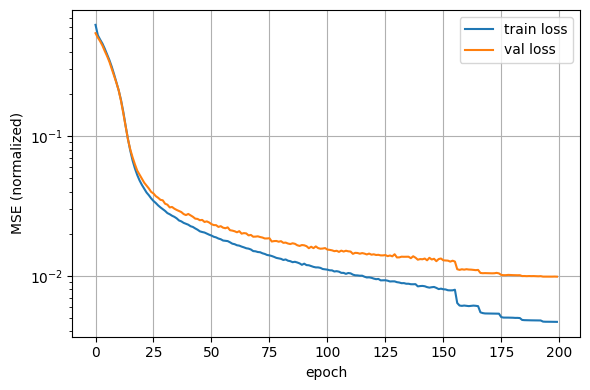

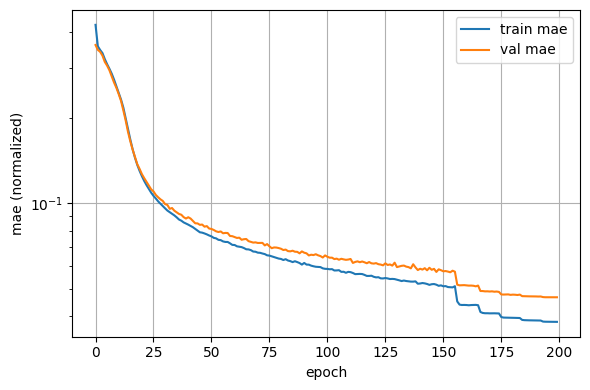

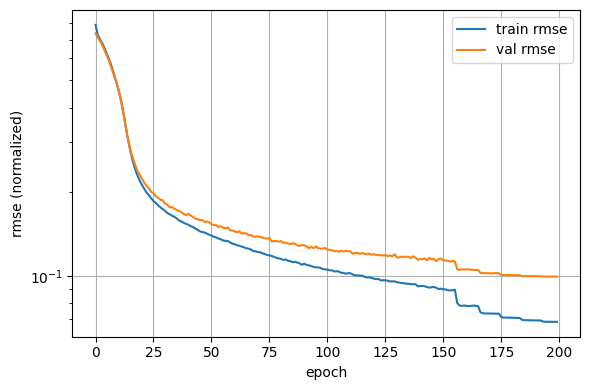

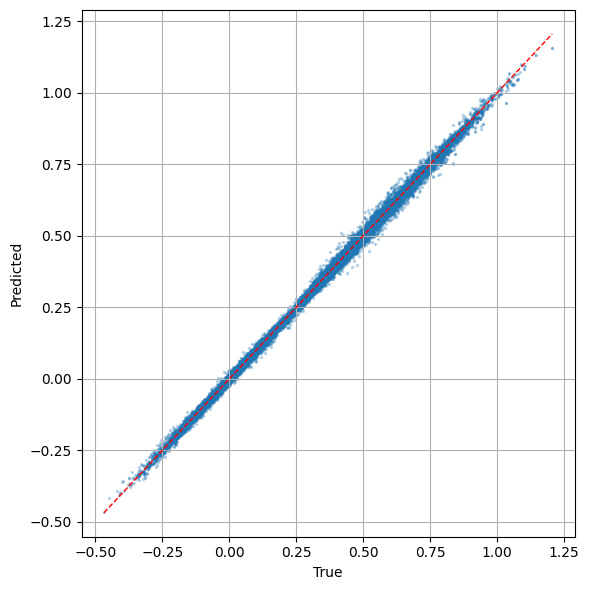

Per-component MAE (min/median/max): 0.0001285688776988536 0.002135785762220621 0.005167113151401281
Per-component RMSE (min/median/max): 0.00017886482237372547 0.0034837694838643074 0.007868827320635319
Global MAE: 0.002183818258345127
Global RMSE: 0.004304591100662947
Test metrics in normalized space: {'loss': 0.009832833893597126, 'mae': 0.047105222940444946, 'rmse': 0.09916064888238907}


In [20]:
# -----------------------
# Example usage
# -----------------------
# X: (N,19), Y: (N,28)
model, hist, (Xte, Yte, Ypred), (x_norm, y_norm), test_metrics_norm = train_regressor_19_to_28(X, Y)
plot_history(hist)
plot_true_vs_pred(Yte, Ypred)
evaluate(Yte, Ypred)
print("Test metrics in normalized space:", test_metrics_norm)